# Ejercicio de Galaxias
##  - Script para cálculo de cinemática estelar

En este script de $\texttt{Python}$ pretendemos calcular el movimiento propio del Sol $(U_\odot, V_\odot, W_\odot)$ a partir de las velocidades espaciales de estrellas cercanas. Una vez hecho eso, podremos además determinar los ejes principales del elipsoide de velocidades.

En primer lugar, incluiremos las dependencias básicas a utilizar.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Podríamos haber usado esta función de Python para calcular U,V,W en coordenadas galácticas 
# en lugar de Topcat
from PyAstronomy.pyasl import gal_uvw

/tmp/ipykernel_32384/873528830.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Con el fin de emplear algunas funcionalidades básicas de Topcat, modificamos en primer lugar los datos proporcionados añadiendo una columna con las velocidades de las estrellas en el sistema de referencia galactocéntrico. Para ello empleamos las funciones del paquete Gaia "astromUVW" para obtener las velocidades en cartesianas con respecto al Sol y "icrsToGal" para referirlas al marco de referencia galáctico.

En este script de Python se lee dicha tabla de datos modificada como un dataframe del paquete Pandas y se extraen todas las variables de interés con el fin de obtener la velocidad del Sol con respecto al LSR y los ejes principales del elipsoide de velocidades en la vecindad solar. Solo necesitaremos las velocidades en coordenadas galácticas, pero viene bien cargar todos los datos en caso de que hagan falta.

In [2]:
data = pd.read_csv("Disk_100pc_old_gal_velocities.csv")

# Posiciones
r = data['DIST_1000'].to_numpy()
RA = data['RA'].to_numpy()
DEC = data['DEC'].to_numpy() 

# Movimiento propio angular y velocidad radial con respecto al Sol
pmRA = data['PMRA'].to_numpy()
pmDEC = data['PMDEC'].to_numpy()
vr = data['RV'].to_numpy()

# Velocidades en coordenadas galácticas
gal_vel = data['(u,v,w)'].to_numpy()


Obtenemos por separado, para cada estrella, las velocidades en la dirección radial U (positiva hacia el centro galáctico), en la dirección de rotación de la galaxia V y hacia el norte galáctico W. Utilizando la definición del LSR, obtenemos así la velocidad del Sol en estas coordenadas como promedio con signo negativo de dichas velocidades.

In [3]:
u = np.zeros_like(gal_vel, dtype=np.float32)
v = np.zeros_like(gal_vel, dtype=np.float32)
w = np.zeros_like(gal_vel, dtype=np.float32)

for i,vel in enumerate(gal_vel):
    u[i] = float(vel.split(', ')[0][1:])
    v[i] = float(vel.split(', ')[1])
    w[i] = float(vel.split(', ')[2][:-1])

usun = -np.nanmean(u)
vsun = -np.nanmean(v)
wsun = -np.nanmean(w)

print('Movimiento solar propio')
print(f'U_sun = {usun:.3f}, \t V_sun = {vsun:.3f}, \t W_sun = {wsun:.3f}')

Movimiento solar propio
U_sun = 9.962, 	 V_sun = 23.032, 	 W_sun = 7.891


Nuestro segundo objetivo es obtener los ejes principales del elipsoide de velocidades en coordenadas galácticas. Para ello, debemos calcular en primer lugar el elipsoide de velocidades. En la base de dispersiones $\Delta u, \Delta v, \Delta w$, los coeficientes de su matriz asociada se obtienen a partir de la matriz de covarianza M, que obtenemos mediante la correspondiente función de Numpy:

In [4]:
delta_u, delta_v, delta_w = u - usun, v - vsun, w - wsun

# Matriz de covarianza
M = np.cov(np.array([delta_u, delta_v, delta_w]))
print(f"Matriz de covarianza: \n {M}\n\n")

print('Desviaciones estándar')
print(f'sigma_U = {np.sqrt(M[0,0])} \t sigma_V = {np.sqrt(M[1,1])} \t sigma_W = {np.sqrt(M[2,2])}')

# Matriz de coeficientes del elipsoide
A = M / np.linalg.det(M)


Matriz de covarianza: 
 [[1556.87442581  104.36526344   -6.39016736]
 [ 104.36526344  932.67223079   27.47751164]
 [  -6.39016736   27.47751164  418.59587617]]


Desviaciones estándar
sigma_U = 39.45724807698291 	 sigma_V = 30.539682886229595 	 sigma_W = 20.459615738597602


A continuación debemos diagonalizar la matriz de coeficientes para obtener sus vectores propios. Este problema se reduce a hallar sus autovalores $\{\lambda_u, \lambda_v, \lambda_w\}$ resolviendo la siguiente ecuación: $$ \mathrm{det} \left( A - \lambda_i \mathbb{1}\right) = 0~.$$

Dado que es una matriz 3x3, podríamos resolver este caso sencillo manualmente. No obstante, dado que el interés de este ejercicio no se encuentra en la pura manipulación algebraica, podemos recurrir de nuevo a Numpy:

In [8]:
"""
Función que diagonaliza una matriz asumiendo que esta es diagonalizable
Input: 
- A: matriz como array de numpy cuadrado
Output: 
- P: matriz de autovectores de A
- D: matriz diagonal de autovalores de A
- P_inv: matriz inversa de P
"""
def diagonalize_matrix(A):

    # Calcula autovalores y autovectores
    eigenvalues, eigenvectors = np.linalg.eig(A)
    
    P = eigenvectors
    D = np.diag(eigenvalues)
    P_inv = np.linalg.inv(P)
    
    return P, D, P_inv

P, D, P_inv = diagonalize_matrix(A)

print(f"Autovalores: lambda_u = {D[0,0]:.3e}, lambda_v = {D[1,1]:.3e}, lambda_w = {D[2,2]:.3e}")
print(f"Autovectores: delta_u' = {P[:, 0]}, delta_v' = {P[:, 1]}, delta_w' = {P[:, 2]}")

Autovalores: lambda_u = 2.614e-06, lambda_v = 1.524e-06, lambda_w = 6.927e-07
Autovectores: delta_u' = [ 0.98702073  0.16058452 -0.00164011], delta_v' = [ 0.16023832 -0.98546841 -0.05635337], delta_w' = [ 0.01066575 -0.05535913  0.99840954]


Por último, podemos graficar el elipsoide de dispersión de velocidades en 3D con $\texttt{Matplotlib}$.

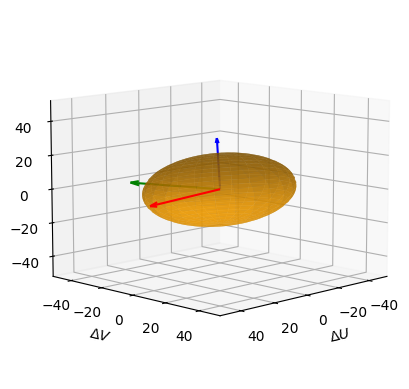

In [10]:
from mpl_toolkits.mplot3d import Axes3D

# Parámetros del elipsoide
a = np.sqrt(D[0,0] * np.linalg.det(M))  # Semieje en u
b = np.sqrt(D[1,1] * np.linalg.det(M))   # Semieje en v
c = np.sqrt(D[2,2] * np.linalg.det(M))  # Semieje en w


'''Elipsoide con ejes propios x,y,z'''
# Coordenadas angulares
theta = np.linspace(0, 2*np.pi, 100)
phi = np.linspace(0, np.pi, 100)

# Coordenadas cartesianas originales
x = a * np.outer(np.cos(theta), np.sin(phi))
y = b * np.outer(np.sin(theta), np.sin(phi))
z = c * np.outer(np.ones_like(theta), np.cos(phi))


'''Rotación del elipsoide a los nuevos ejes propios'''
# Aplicar la rotación a las coordenadas
x_rot, y_rot, z_rot = np.dot(P, np.array([x.flatten(), y.flatten(), z.flatten()]))

# Reshape de las coordenadas rotadas
x_rot = x_rot.reshape(x.shape)
y_rot = y_rot.reshape(y.shape)
z_rot = z_rot.reshape(z.shape)


'''Graficar el elipsoide'''
# Crear la figura y los ejes 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Dibujar los ejes principales
origin = [0, 0, 0]
ax.quiver(*origin, *P[:, 0] * 50, color='r', arrow_length_ratio=0.1)
ax.quiver(*origin, *P[:, 1] * 50, color='g', arrow_length_ratio=0.1)
ax.quiver(*origin, *P[:, 2] * 30, color='b', arrow_length_ratio=0.1)

# Graficar el elipsoide rotado
ax.plot_surface(x_rot, y_rot, z_rot, color='orange', rstride=4, cstride=4, alpha=0.7)


# Etiquetas de los ejes
ax.set_xlabel('$\Delta U$')
ax.set_ylabel('$\Delta V$')
ax.set_zlabel('$\Delta W$')

ax.set_xlim(-50,50)
ax.set_ylim(-50,50)
ax.set_zlim(-50,50)

ax.view_init(elev=10, azim=45)

# Mostrar el gráfico
plt.show()
